**<font size = 4> <font color = 'red'> IMPORT MODULES**

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

**<font size = 4> <font color = 'red'> READ IN MATCHUP DATA**

In [3]:
nba_series = pd.read_csv("TEAM_MATCHUP_DATA_FINAL.csv") # replace with your path
nba_series['SEASON'] = nba_series['SEASON'].astype(int)

**<font size = 4> <font color = 'red'> SET UP TRAIN/TEST DATA**

In [5]:
# Trained on data from 1997-1999 and tested on 2000 data
train_data_gen = nba_series[nba_series['SEASON'] < 2020]
test_data_gen = nba_series[nba_series['SEASON'] >= 2020]

# Separate out the columns to keep for comparison
columns_to_keep = ['SERIES_ID', 'SEASON', 'TEAM_1', 'TEAM_2', 'SERIES_WINNER']
# Save the original data with the columns to keep
train_data_preserved = train_data_gen[columns_to_keep]
test_data_preserved = test_data_gen[columns_to_keep]

# Drop columns before training the model
nba_series = nba_series.drop(columns = ['SERIES_ID', 'SEASON', 'SEASON_ID', 'TEAM_1_ID', 'TEAM_2_ID'])
train_data_gen = train_data_gen.drop(columns = ['SERIES_ID', 'SEASON', 'SEASON_ID', 'TEAM_1_ID', 'TEAM_2_ID'])
test_data_gen = test_data_gen.drop(columns = ['SERIES_ID', 'SEASON', 'SEASON_ID', 'TEAM_1_ID', 'TEAM_2_ID'])

# Set up the target variable as TEAM_1_W and drop TEAM_1, TEAM_2, and SERIES_WINNER variables
nba_series['TEAM_1_W'] = (nba_series['SERIES_WINNER'] == nba_series['TEAM_1']).astype(int)
nba_series = nba_series.drop(columns = ['TEAM_1', 'TEAM_2', 'SERIES_WINNER'])

train_data_gen['TEAM_1_W'] = (train_data_gen['SERIES_WINNER'] == train_data_gen['TEAM_1']).astype(int)
train_data_gen = train_data_gen.drop(columns = ['TEAM_1', 'TEAM_2', 'SERIES_WINNER'])

test_data_gen['TEAM_1_W'] = (test_data_gen['SERIES_WINNER'] == test_data_gen['TEAM_1']).astype(int)
test_data_gen = test_data_gen.drop(columns = ['TEAM_1', 'TEAM_2', 'SERIES_WINNER'])

In [ ]:
import os
# Defines output folder to store panda data frames as csv files
output_folder = r"C:\Users\Sarvesh\Desktop\NBACluster Project"
# Stores the regular season data frames as csv files to the desktop
nba_series.to_csv(os.path.join(output_folder, "VIEW_FILT_DATA.csv"), index = False)

**<font size = 4> <font color = 'red'> NEURAL NETWORK TRAINING/TESTING (FULL DATA)**

C:\Users\Sarvesh\anaconda3\envs\NBACluster\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.5705 - loss: 5.5350 - val_accuracy: 0.6614 - val_loss: 5.0362
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7042 - loss: 4.8695 - val_accuracy: 0.6614 - val_loss: 4.4666
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7758 - loss: 4.2840 - val_accuracy: 0.7249 - val_loss: 3.9287
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8003 - loss: 3.7494 - val_accuracy: 0.7566 - val_loss: 3.4986
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8073 - loss: 3.3024 - val_accuracy: 0.7566 - val_loss: 3.1250
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8758 - loss: 2.8780 - val_accuracy: 0.7989 - val_loss: 2.7784
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9011 - loss: 2.5590 - val_accuracy: 0.7672 - val_loss: 2.5532
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8593 - loss: 2.3210 - val_accuracy: 0.7884 - v

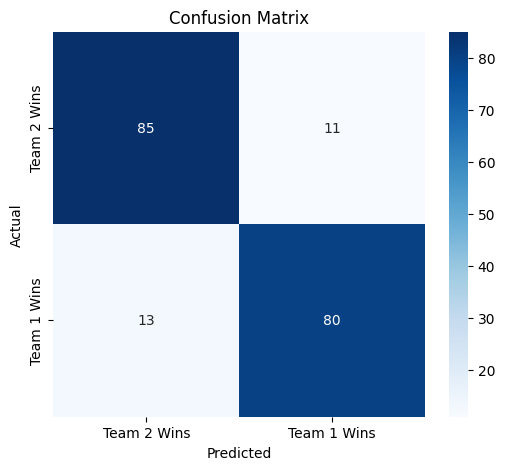

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


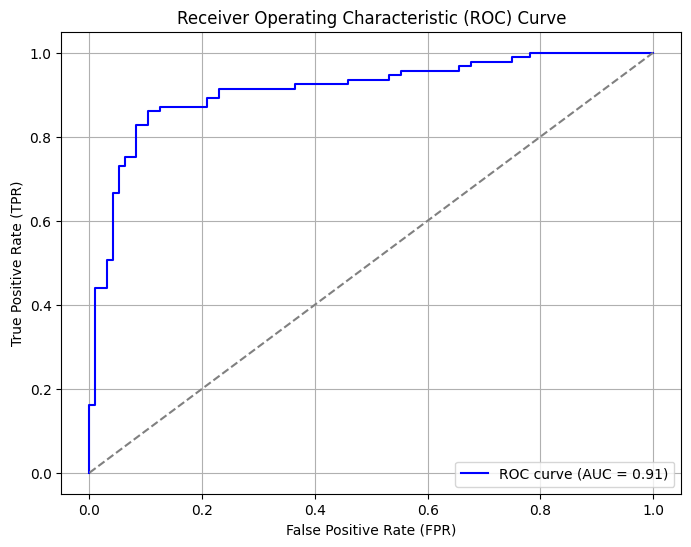

In [7]:
# Load the dataset (nba_series) and separate features (X) and target (y)
X = nba_series.drop(columns=['TEAM_1_W'])
y = nba_series['TEAM_1_W']

# Handle class imbalance using SMOTE
smote = SMOTE(sampling_strategy='minority', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Standardize the features
scaler = StandardScaler()
X_resampled = scaler.fit_transform(X_resampled)

# Compute class weights to handle imbalance
class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=y_resampled)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# Build the neural network model
model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation='relu', input_dim=X_train.shape[1], kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# Set up early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test),
                    class_weight=class_weight_dict, callbacks=[early_stopping])

# Make predictions
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Evaluate the model
print(f"Model Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Team 2 Wins', 'Team 1 Wins'], 
            yticklabels=['Team 2 Wins', 'Team 1 Wins'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Get the predicted probabilities for the positive class (Team 1 Wins)
y_prob = model.predict(X_test)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (no discrimination)
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [9]:
from sklearn.model_selection import StratifiedKFold
import numpy as np

# Define the number of folds
num_folds = 5
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Store results
fold_accuracies = []
fold_auc_scores = []

for train_idx, val_idx in skf.split(X_resampled, y_resampled):
    # Split data into train and validation sets
    X_train, X_val = X_resampled[train_idx], X_resampled[val_idx]
    y_train, y_val = y_resampled[train_idx], y_resampled[val_idx]

    # Build the model inside the loop
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation='relu', input_dim=X_train.shape[1], kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val),
              class_weight=class_weight_dict, callbacks=[early_stopping], verbose=0)

    # Evaluate the model
    y_pred = (model.predict(X_val) > 0.5).astype("int32")
    y_prob = model.predict(X_val)

    # Compute accuracy
    accuracy = accuracy_score(y_val, y_pred)
    fold_accuracies.append(accuracy)

    # Compute AUC
    fpr, tpr, _ = roc_curve(y_val, y_prob)
    roc_auc = auc(fpr, tpr)
    fold_auc_scores.append(roc_auc)

    print(f"Fold Accuracy: {accuracy * 100:.2f}%, AUC: {roc_auc:.2f}")

# Compute the average performance
print(f"\nAverage Accuracy: {np.mean(fold_accuracies) * 100:.2f}% ± {np.std(fold_accuracies) * 100:.2f}%")
print(f"Average AUC: {np.mean(fold_auc_scores):.2f} ± {np.std(fold_auc_scores):.2f}")

C:\Users\Sarvesh\anaconda3\envs\NBACluster\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Fold Accuracy: 81.75%, AUC: 0.91


C:\Users\Sarvesh\anaconda3\envs\NBACluster\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Fold Accuracy: 88.10%, AUC: 0.95


C:\Users\Sarvesh\anaconda3\envs\NBACluster\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Fold Accuracy: 88.89%, AUC: 0.94


C:\Users\Sarvesh\anaconda3\envs\NBACluster\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Fold Accuracy: 86.40%, AUC: 0.91


C:\Users\Sarvesh\anaconda3\envs\NBACluster\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Fold Accuracy: 82.40%, AUC: 0.91

Average Accuracy: 85.51% ± 2.92%
Average AUC: 0.92 ± 0.02


**<font size = 4> <font color = 'red'> NEURAL NETWORK TRAINING (1997-2004), TESTING (2005)**

Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9350 - loss: 0.4680 - val_accuracy: 0.9067 - val_loss: 0.5114
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9300 - loss: 0.4604 - val_accuracy: 0.9067 - val_loss: 0.5192
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9409 - loss: 0.4126 - val_accuracy: 0.8933 - val_loss: 0.5306
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9684 - loss: 0.3767 - val_accuracy: 0.8933 - val_loss: 0.5026
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9581 - loss: 0.3924 - val_accuracy: 0.8667 - val_loss: 0.5203
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9697 - loss: 0.3493 - val_accuracy: 0.8667 - val_loss: 0.5516
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9744 - loss: 0.3199 - val_accuracy: 0.8533 - val_loss: 0.5666
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9848 - loss: 0.3149 - val_accuracy: 0.8800 - v

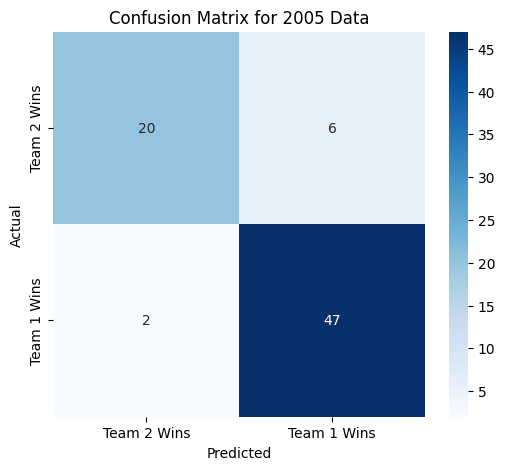

In [11]:
# Make predictions on the 2016 data
# Assuming you have already split into 1997-2015 (training) & 2016 (testing)
X_train_gen = train_data_gen.drop(columns=['TEAM_1_W'])
y_train_gen = train_data_gen['TEAM_1_W']
X_test_gen = test_data_gen.drop(columns=['TEAM_1_W'])
y_test_gen = test_data_gen['TEAM_1_W']

# Standardize the features for 2024 data
X_train_gen = scaler.transform(X_train_gen)
X_test_gen = scaler.transform(X_test_gen)

# Train the model
model.fit(X_train_gen, y_train_gen, epochs=50, batch_size=32, validation_data=(X_test_gen, y_test_gen),
          class_weight=class_weight_dict, callbacks=[early_stopping])

# Make predictions on the 2016 test data
y_pred_gen = (model.predict(X_test_gen) > 0.5).astype("int32")

# Evaluate the model on 2024 data
print(f"Accuracy on 2005 data: {accuracy_score(y_test_gen, y_pred_gen) * 100:.2f}%")
print("\nClassification Report for 2005 data:")
print(classification_report(y_test_gen, y_pred_gen))

# Confusion matrix for 2024 data
cm_24 = confusion_matrix(y_test_gen, y_pred_gen)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_24, annot=True, fmt='d', cmap='Blues', xticklabels=['Team 2 Wins', 'Team 1 Wins'], 
            yticklabels=['Team 2 Wins', 'Team 1 Wins'])
plt.title('Confusion Matrix for 2005 Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

**<font size = 4> <font color = 'red'> DISPLAY FINAL RESULTS**

In [ ]:
test_data_preserved['PRED_WINNER'] = y_pred_gen
test_data_preserved